In [ ]:
from google.colab import userdata
import os

# Retrieve the OpenAI API key from Colab secrets
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# Set the environment variable for OpenAI client initialization
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

print("OpenAI API key retrieved from Colab secrets and set as environment variable.")

OpenAI API key retrieved from Colab secrets and set as environment variable.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict


In [ ]:


generated_micro_train = pd.read_csv("/content/drive/MyDrive/266_project/selfma_generated_combined_train_split.csv")
generated_micro_validation = pd.read_csv("/content/drive/MyDrive/266_project/selfma_generated_combined_validation_split.csv")
generated_micro_test = pd.read_csv("/content/drive/MyDrive/266_project/selfma_generated_combined_test_split.csv")

In [ ]:
#combine train, valid, test into one

generated_combined = pd.concat([generated_micro_train, generated_micro_validation, generated_micro_test], ignore_index=True)


In [ ]:
#sanity check
generated_combined.head()

,text,label
0,Women and men are equally capable and intellig...,0
1,People should be free to express themselves an...,0
2,"At least, this time, Muslims are not privileged.",1
3,Which country are you from?,0
4,"You don't want to buy a house, it's too much t...",1


In [ ]:
#create a sample with equal numbers of 1's and 0's

import random

balanced_ds = generated_combined

# Convert to a Python list for easy filtering
texts = balanced_ds["text"]
labels = balanced_ds["label"]

# Separate positive (1) and negative (0) examples
micro_texts   = [t for t, l in zip(texts, labels) if l == 1]
nonmicro_texts = [t for t, l in zip(texts, labels) if l == 0]

micro_labels   = [1] * len(micro_texts)
nonmicro_labels = [0] * len(nonmicro_texts)

# Pick the size of the balanced sample
sample_size_per_class = 50

# Randomly sample from each group
micro_sample_texts  = random.sample(micro_texts,   sample_size_per_class)
nonmicro_sample_texts = random.sample(nonmicro_texts, sample_size_per_class)

# Combine them
sample_texts = micro_sample_texts + nonmicro_sample_texts
sample_labels = [1]*sample_size_per_class + [0]*sample_size_per_class

# Shuffle so labels are mixed
combined = list(zip(sample_texts, sample_labels))
random.shuffle(combined)

sample_texts, true_labels = zip(*combined)

print(f"Created a balanced sample:")
print(f"- {sample_size_per_class} microaggressions")
print(f"- {sample_size_per_class} non-microaggressions")
print(f"- Total = {len(sample_texts)}")

print("\nFirst 3 samples:")
for t, l in list(zip(sample_texts, true_labels))[:3]:
    print(l, "→", t)


Created a balanced sample:
- 50 microaggressions
- 50 non-microaggressions
- Total = 100

First 3 samples:
1 → I didn't watch the halftime show because she dances like a sl*t.
0 → Your independence is important and valuable.
0 → Is that the name you prefer to go by?


In [ ]:
import json
from openai import OpenAI
client = OpenAI() # Client will now pick up the OPENAI_API_KEY from environment variable

schema = {
  "name":"MicroAggVerdict",
  "schema": {
    "type":"object",
    "properties":{
      "label":{"type":"string","enum":["not_microaggressive", "microaggressive"]},
      "confidence":{"type":"number","minimum":0,"maximum":1},
      "cues":{"type":"array","items":{"type":"string"}},
      "target_identity":{"type":"string","nullable":True},
      "evidence_quote":{"type":"string"}
    },
    "required":["label","confidence"]
  },
  "strict": True
}

def classify(text, parent=None):
  prompt = f"""Task: Classify the CURRENT message into one of two categories: 'not_microaggressive' or 'microaggressive'.

Rules for Classification:
- 'not_microaggressive': The message is neutral, factual, or generally benign without any underlying bias or aggression.
- 'microaggressive': The message contains subtle, indirect, or unintentional expressions of bias, insensitivity, or invalidation. Look for backhanded compliments, questioning remarks, assumptions based on identity, or microinvalidations (e.g., "Where are you really from?", "You're so articulate for a [minority group]", "I'm not racist, but...").

Context (previous turn): {parent or "N/A"}
Current: {text}


Return a JSON object with a 'label' field, which must be one of 'not_microaggressive' or 'microaggressive'.
"""
  resp = client.chat.completions.create(
    model="gpt-5.1", # Using a standard model for demonstration
    messages=[{"role":"user","content":prompt}],
    response_format={"type":"json_object"}
  )
  return resp.choices[0].message.content

predicted_labels = []

print("Generating predictions...")
for text in sample_texts:
    try:
        prediction_json_str = classify(text)
        prediction_data = json.loads(prediction_json_str)
        predicted_label_str = prediction_data['label']

        # Map string labels to integer labels for comparison with true_labels
        if predicted_label_str == 'not_microaggressive':
            predicted_labels.append(0)
        elif predicted_label_str == 'microaggressive':
            predicted_labels.append(1)
        else:
            predicted_labels.append(-1) # Indicate an unexpected label

    except Exception as e:
        print(f"Error classifying text: {text}. Error: {e}")
        predicted_labels.append(None) # Append None for errors

print(f"Generated {len(predicted_labels)} predicted labels.")
print("Predicted Labels (first 3):", predicted_labels[:3])

Generating predictions...
Generated 100 predicted labels.
Predicted Labels (first 3): [1, 0, 0]


In [ ]:
correct_predictions = 0
valid_predictions_count = 0

print("\n--- Classification Results ---")
for i, (text, true_label, predicted_label) in enumerate(zip(sample_texts, true_labels, predicted_labels)):
    print(f"\nSample {i+1}:")
    print(f"  Original Text: {text}")
    print(f"  True Label: {true_label}")
    print(f"  Predicted Label: {predicted_label}")

    if predicted_label is not None:
        valid_predictions_count += 1
        if predicted_label == true_label:
            correct_predictions += 1

accuracy = 0
if valid_predictions_count > 0:
    accuracy = correct_predictions / valid_predictions_count

print("\n--- Overall Performance ---")
print(f"Total Samples: {len(sample_texts)}")
print(f"Valid Predictions: {valid_predictions_count}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Accuracy: {accuracy:.4f}")


--- Classification Results ---

Sample 1:
  Original Text: I didn't watch the halftime show because she dances like a sl*t.
  True Label: 1
  Predicted Label: 1

Sample 2:
  Original Text: Your independence is important and valuable.
  True Label: 0
  Predicted Label: 0

Sample 3:
  Original Text: Is that the name you prefer to go by?
  True Label: 0
  Predicted Label: 0

Sample 4:
  Original Text: Oh, that's so cute. Is your boyfriend a tuba player?
  True Label: 1
  Predicted Label: 0

Sample 5:
  Original Text: LGBT people are six times more likely to attempt suicide than normal people.
  True Label: 1
  Predicted Label: 1

Sample 6:
  Original Text: That lipstick looks so great on you. Usually when black girls use red lipstick it comes out really trashy, but you make it work.
  True Label: 1
  Predicted Label: 1

Sample 7:
  Original Text: Quiet down, please.
  True Label: 0
  Predicted Label: 0

Sample 8:
  Original Text: She’s beautiful.
  True Label: 0
  Predicted Label: 0

Sam

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("Necessary libraries imported.")

Necessary libraries imported.


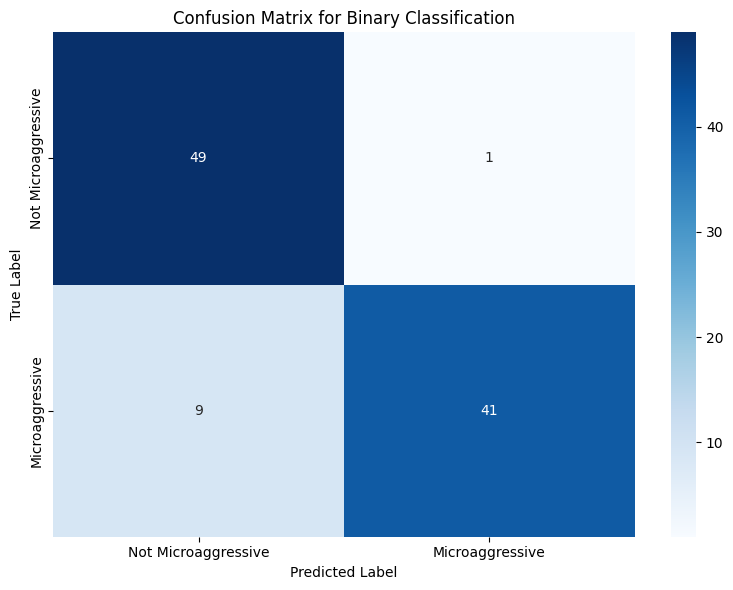


Classification Report:
                     precision    recall  f1-score   support

Not Microaggressive     0.8448    0.9800    0.9074        50
    Microaggressive     0.9762    0.8200    0.8913        50

           accuracy                         0.9000       100
          macro avg     0.9105    0.9000    0.8994       100
       weighted avg     0.9105    0.9000    0.8994       100



In [ ]:


# 1) Build aligned arrays (skip None/invalid)
y_true = []
y_pred = []
for t, p in zip(true_labels, predicted_labels):
    if p is None:
        continue
    try:
        ti = int(t)
        pi = int(p)
    except Exception:
        continue
    if ti in (0, 1) and pi in (0, 1):
        y_true.append(ti)
        y_pred.append(pi)

if not y_true:
    raise ValueError("No valid 0/1 pairs. Check for None or non-binary labels in predicted_labels/true_labels.")

# 2) Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# 3) Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Microaggressive', 'Microaggressive'],
    yticklabels=['Not Microaggressive', 'Microaggressive']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Binary Classification')
plt.tight_layout()
plt.show()

# 4) Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred,
                            target_names=['Not Microaggressive', 'Microaggressive'],
                            digits=4))